In [51]:
import numpy as np
import scipy as sp
import pandas as pd

import scipy.interpolate as interpolate

import matplotlib.pyplot as plt

%matplotlib inline

In [52]:
N = 5
test_N = 100

In [53]:
# function to approximate

def target_fn(x):
    return np.sin(x)

# sample from the target function

def sample(n, noise=False):
    x = np.sort(np.random.randn(n))
    samples = target_fn(x)
    
    if noise:
        samples += np.random.randn(n)
    
    return x, samples

In [54]:
# to smooth the resulting curves

def smooth(x, y):
    
    x_smooth = np.linspace(x.min(), x.max(), 300)
    
    t, c, k = interpolate.splrep(x, y, s=0, k=3)
    
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    
    y_smooth = spline(x_smooth)
    
    return x_smooth, y_smooth

# GP using noise-free observations

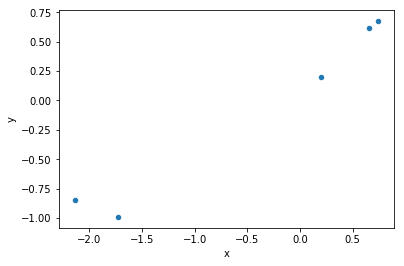

In [55]:
# sample the training

train_x, train_y = sample(N)
data = pd.DataFrame({"x": train_x, "y": train_y})
data.plot.scatter(x="x", y="y")

In [56]:
# sample test

test_x, test_y = sample(test_N)
test_x = np.sort(np.concatenate([test_x, train_x]))

In [57]:
def kernel(x, x_):
    return np.exp(-.5*(x - x_)**2)

def cov(x, x_):
    xx, xx_ = np.meshgrid(x, x_)
    
    return np.reshape(kernel(xx, xx_), (x.shape[0], x_.shape[0]))

# prior probability

def gp_prior(x):
    
    return np.zeros(x.shape[0]), cov(x, x)

# posterior probability

def gp_posterior(x, y, test_x):
    
    K_train = cov(x, x)
    K_test = cov(test_x, test_x)
    K_train_test = cov(x, test_x)
    
    K_train_inv = sp.linalg.inv(K_train)
    
    KK = np.dot(np.transpose(K_train_test), K_train_inv)
    
    mu = np.dot(KK, y)
    sigma = K_test - np.dot(KK, K_train_test)
    
    return mu, sigma

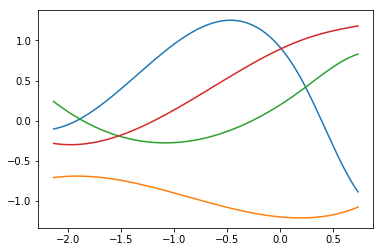

In [58]:
# sample curves from the prior

prior_mu, prior_sigma = gp_prior(train_x)

curves_num = 4

ax = plt.subplot(111)

for c in range(curves_num):
    y = np.random.multivariate_normal(prior_mu, prior_sigma)
    
    train_x_smooth, y_smooth = smooth(train_x, y)
    
    ax.plot(train_x_smooth, y_smooth)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


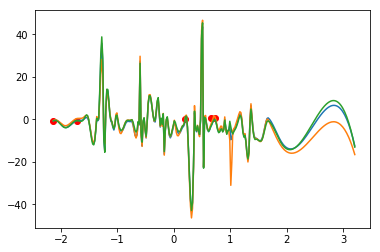

In [59]:
# sample after observing data

post_mu, post_sigma = gp_posterior(train_x, train_y, test_x)

post_curves_num = 3

ax = plt.subplot(111)

for c in range(post_curves_num):
    y_hat = np.random.multivariate_normal(post_mu, post_sigma)
    test_x_smooth, y_hat_smooth = smooth(test_x, y_hat)
    ax.plot(test_x_smooth, y_hat_smooth)

ax.scatter(train_x, train_y, c="red")